This notebook will detail my attempts at getting video and acoustic tracking for the speaker playbacks. This is a simple recording to handle. 

* Speaker recording: SPKRPLAYBACK_multichirp_2018-07-29_09-42-59.WAV
* Video recording : 2018-07-28/P03/K1,2,3/02000.TMC


In [1]:
import datetime as dt
import scipy.signal as signal 
import scipy.spatial as spatial
import scipy.ndimage as ndimage
import soundfile as sf
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
print(f'Notebook cell run at {dt.datetime.now()}')

Notebook cell run at 2021-06-28 11:29:31.606957


In [3]:
import batracker
from batracker.localisation import friedlander_1987 as fr87
from batracker.localisation import schau_robinson_1987 as sr87
from batracker.localisation import spiesberger_wahlberg_2002 as sw02

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from batracker.signal_detection.detection import cross_channel_threshold_detector
from batracker.signal_detection.detection import envelope_detector
from batracker.tdoa_estimation.tdoa_estimators import measure_tdoa
from batracker.correspondence_matching.multichannel_match import generate_crosscor_boundaries

In [4]:
%matplotlib notebook

In [5]:
folder = 'E://fieldwork_2018_002/actrackdata/wav/2018-07-28_003/'
filename = 'SPKRPLAYBACK_multichirp_2018-07-29_09-42-59.WAV'
# take out only the first 20 s with 4 channels + the cam sync and electronic output signal
fs = 192000
audio, fs = sf.read(folder+filename, stop=int(fs*20))
part_audio = audio[:,[0,1,2,3,6,7]]
sf.write('multichirp_sankenscamerasyncoutput_2018-07-29_09-42-59.wav', part_audio, fs)

In [6]:
audiofile = 'multichirp_sankenscamerasyncoutput_2018-07-29_09-42-59.wav'
# gwt only first 2 s for now. 
audio, fs = sf.read(audiofile, stop=int(192000*7.5))

In [7]:
# get all audio that start from frame 1 of the camera sync signal (1st frame that is +ve)
first_frame_sample = np.min(np.argwhere(audio[:,-1]>=np.percentile(audio[:,-1],95)))
# audio sync'ed with 1st camera frame
cam_audio = audio[first_frame_sample:,:]

print(first_frame_sample/fs)
# get the array audio 
array_audio = cam_audio[:,:4]

1.2398802083333333


In [8]:
b,a = signal.butter(2,np.array([30e3,90e3])/(fs*.5),'bandpass')
array_audiohp = np.apply_along_axis(lambda X: signal.filtfilt(b,a,X),0,array_audio)

In [9]:
positive, num_regions = ndimage.label(cam_audio[:,-1]>0)
frames = ndimage.find_objects(positive)
frame_start_times = [each[0].start/fs for each in frames]

In [10]:
digital_pbk_env = abs(signal.hilbert(cam_audio[:,-2]))


In [11]:
playbacks, num_pbks = ndimage.label(digital_pbk_env>0.005)
playback_chunks = ndimage.find_objects(playbacks)
playback_midpoints = np.array([np.mean([each[0].stop,each[0].start])/fs for each in playback_chunks])
# This will give the exact frame numbers to digitise
fps = 25

playback_frames = np.array(playback_midpoints*fps, dtype=np.int32)+1 # to include the fact that frame 1 is the starting

In [12]:
playback_frames

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  90,  95, 100, 105,
       110, 115, 120, 125, 130])

<IPython.core.display.Javascript object>


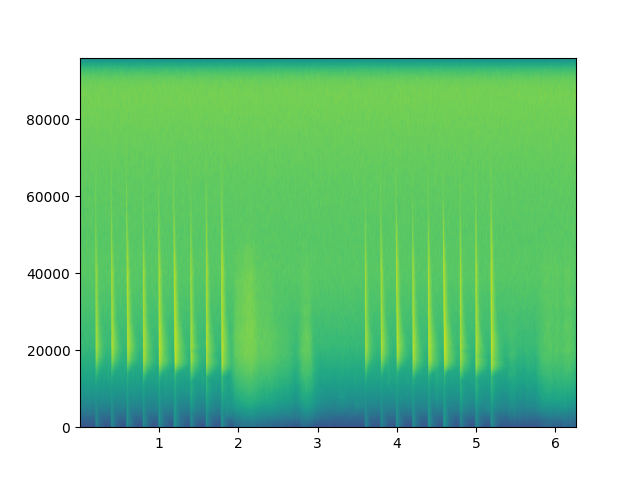

In [13]:
plt.figure()
plt.specgram(array_audiohp[:,0],Fs=fs);

In [14]:
detections = cross_channel_threshold_detector(array_audiohp, fs,
                                              detector_function=envelope_detector,
                                              threshold_db_floor=12,
                                              lowpass_durn=0.004)
# for now just use manual detections to generate the correlation boundaries

              
    
            

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

4 1201943


c:\users\tbeleyur\documents\research_repos\batracker\batracker\signal_detection\detection.py:163: RuntimeWarning: invalid value encountered in log10
  floor_level = np.percentile(20*np.log10(envelope),5)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30it/s]


<IPython.core.display.Javascript object>


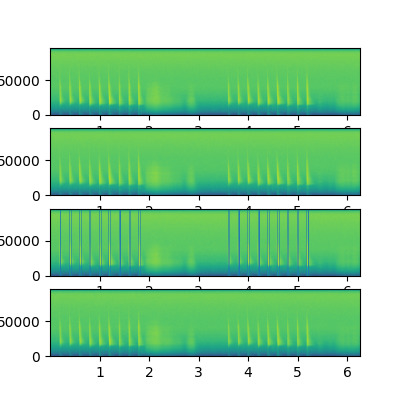

In [15]:
                                    
# Spectrogram of the cross-corr boundaries
plt.figure(figsize=(4,4))
ax= plt.subplot(411)
plt.specgram(array_audiohp[:,0], Fs=fs)
for each in detections[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(array_audiohp[:,i-1], Fs=fs)
    for each in detections[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)

In [16]:
# filter all detections, and keep only those that are >1 ms long. 
min_durn = 0.0075
filtered_detections = []
for channel_dets in detections:
    long_detections = [] 
    for detn in channel_dets:
        if detn[1]-detn[0]>=min_durn:
            long_detections.append(detn)
    filtered_detections.append(long_detections) # Spectrogram of the cross-corr boundaries plt.figure() ax= plt.subplot(411) plt.specgram(audio[:,0], Fs=fs) for each in filtered_detections[0]: plt.vlines(each, 0, fs*0.5, linewidth=0.4) for i in range(2,5): plt.subplot(410+i, sharex=ax) plt.specgram(audio[:,i-1], Fs=fs) for each in filtered_detections[i-1]: plt.vlines(each, 0, fs*0.5, linewidth=0.4)filtered_detections

In [17]:
[len(each)for each in filtered_detections]

[0, 0, 18, 0]

<IPython.core.display.Javascript object>


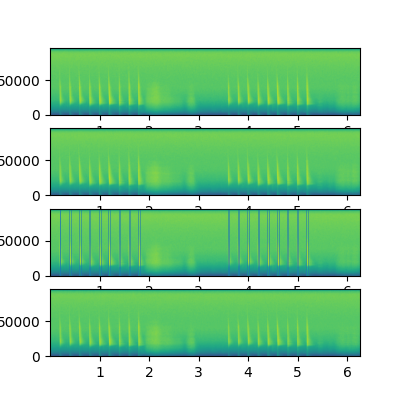

In [18]:
                                    
# Spectrogram of the cross-corr boundaries
plt.figure(figsize=(4,4))
ax= plt.subplot(411)
plt.specgram(array_audiohp[:,0], Fs=fs)
for each in filtered_detections[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(array_audiohp[:,i-1], Fs=fs)
    for each in filtered_detections[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)

In [19]:
# Array geometry
## What we expect it to be theoretically
R = 1.2 # meters
theta = np.pi/3
other_x_position = 0.5
theta2 = np.arctan(other_x_position/(R*np.cos(theta)))
R_2 = np.sqrt(other_x_position**2 +  (R*np.cos(theta))**2)
arbit_y = 0
mic_positions = np.array([[0,arbit_y,0],
                          [R_2*np.sin(theta2),  arbit_y, -R*np.cos(theta), ],
                          [-R*np.sin(theta), arbit_y, -R*np.cos(theta)],
                          [0,arbit_y,R]])
mic_positions[:,1] = np.random.normal(0,1e-5,4)
ag = pd.DataFrame(mic_positions)
ag.columns  = ['x','y','z']

In [20]:

crosscor_boundaries = [(0.19,0.205),(0.387,0.402), (0.576,0.602),
                        (0.79,0.8), (0.985,1.0), (1.175, 1.2),
                       (1.39, 1.399), (1.585, 1.595), (1.774, 1.794),
                      (3.593, 3.603), (3.785,3.802), (3.98, 4),
                      (4.191,4.2), (4.385,4.4), (4.575,4.6),
                      (4.79, 4.80), (4.985,5.0), (5.175, 5.199)]    

<IPython.core.display.Javascript object>


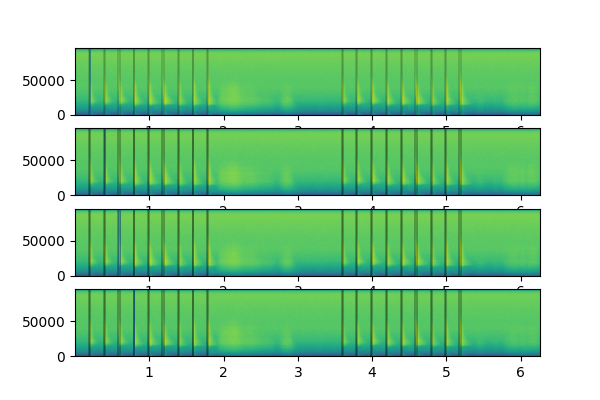

In [21]:
# Spectrogram of the cross-corr boundaries
plt.figure(figsize=(6,4))
ax= plt.subplot(411)
plt.specgram(array_audiohp[:,0], Fs=fs)
for each in crosscor_boundaries[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)
    
for each in crosscor_boundaries:
    plt.vlines(each, 0, fs*0.5, linewidth=0.2, color='k', alpha=1)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(array_audiohp[:,i-1], Fs=fs)
    for each in crosscor_boundaries[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)
        for each in crosscor_boundaries:
            plt.vlines(each, 0, fs*0.5, linewidth=0.2, color='k', alpha=1)

In [22]:
# trying out gcc-phat

"""
 Estimate time delay using GCC-PHAT 
 Copyright (c) 2017 Yihui Xiong
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
     http://www.apache.org/licenses/LICENSE-2.0
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

import numpy as np


def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc


In [23]:
reference_ch = 0
gcc_phat_tdoas = {}
other_channels = list(set(range(4))-set([reference_ch]))
all_tdoas = {}
for i,each_common in enumerate(crosscor_boundaries):
    start, stop = each_common
    start_sample, stop_sample = int(start*fs), int(stop*fs)
    tdoas_gcc_phat = []
    for each in other_channels:
        ccmax, cc = gcc_phat(array_audiohp[start_sample:stop_sample,each],
                                 array_audiohp[start_sample:stop_sample,reference_ch])
        tdoas_gcc_phat.append(ccmax/fs)

    tdoas = measure_tdoa(array_audiohp[start_sample:stop_sample,:], fs, ref_channel=reference_ch)
    gcc_phat_tdoas[i] = np.array(tdoas_gcc_phat)
    all_tdoas[i] = tdoas

In [24]:
array_audiohp.shape

(1201943, 4)

In [25]:
# Using the Time of emission to get TDOAs
reference_audio = cam_audio[:,-2]
gcc_phat_tof = {}
other_channels = list(range(4))
all_tofs = {}
for i,each_common in enumerate(crosscor_boundaries):
    start, stop = each_common
    start_sample, stop_sample = int(start*fs), int(stop*fs)
    tof_gcc_phat = []
    playback_chunk_start = playback_chunks[i][0].start
    for each in other_channels:
        ccmax, cc = gcc_phat(array_audiohp[playback_chunk_start:stop_sample,each],
                                 reference_audio[playback_chunk_start:stop_sample])
        #cc = signal.correlate(array_audiohp[playback_chunk_start:stop_sample,each],
        #                         reference_audio[playback_chunk_start:stop_sample],
        #                        'same')
        #ccmax = np.argmax(cc) - cc.size/2.0
        tof_gcc_phat.append(ccmax/fs)
    all_tofs[i] = np.array(tof_gcc_phat)

# set 0 channel as ref
tdoas_tofbased = {}
for i, tofs in all_tofs.items():
    tdoas_tofbased[i] = tofs[1:]-tofs[0]

0.0192421875 0.01925390625


<IPython.core.display.Javascript object>


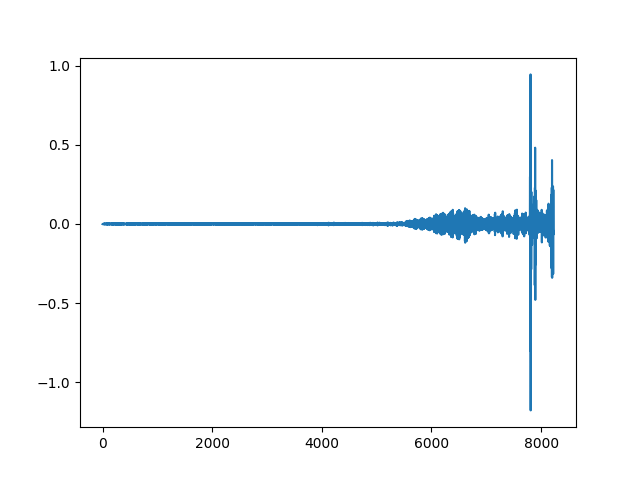

In [26]:
cc = signal.correlate(array_audiohp[playback_chunk_start:stop_sample,each],
                                 reference_audio[playback_chunk_start:stop_sample],'same')
delay = (np.argmax(cc) - cc.size/2.0)/fs

print(delay, ccmax/fs)

plt.figure()
plt.plot(cc)

In [27]:
all_tofs

{0: array([0.01768229, 0.01628516, 0.01832878, 0.01847526]),
 1: array([0.01766797, 0.01627181, 0.01830306, 0.01846224]),
 2: array([0.01766081, 0.01626497, 0.01829557, 0.01845508]),
 3: array([0.01765202, 0.01625716, 0.01829785, 0.01844694]),
 4: array([0.01764551, 0.01625065, 0.01829134, 0.01843945]),
 5: array([0.01764648, 0.0162513 , 0.01828255, 0.01843978]),
 6: array([0.0176582 , 0.01626204, 0.0182946 , 0.01845085]),
 7: array([0.01767318, 0.01627604, 0.01832129, 0.01846582]),
 8: array([0.01766439, 0.01622721, 0.01829818, 0.01846094]),
 9: array([0.01813086, 0.01680632, 0.01834701, 0.01940853]),
 10: array([0.01811165, 0.01678939, 0.0183252 , 0.01939323]),
 11: array([0.01809635, 0.01677962, 0.01832129, 0.01937272]),
 12: array([0.01808529, 0.01677083, 0.01830208, 0.01936003]),
 13: array([0.01807422, 0.01675944, 0.0182998 , 0.01934896]),
 14: array([0.01807064, 0.01674837, 0.01828776, 0.01934375]),
 15: array([0.01803939, 0.01673079, 0.01825911, 0.01930794]),
 16: array([0.0180

<IPython.core.display.Javascript object>


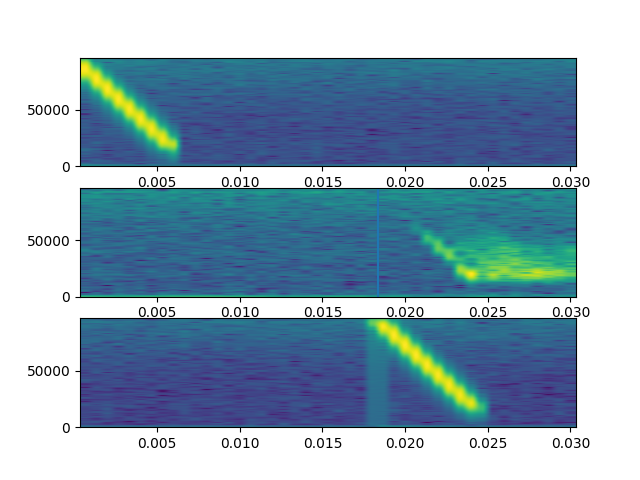

In [28]:
audio_ch = 2
start = playback_chunks[0][0].start
stop = int(crosscor_boundaries[0][1]*fs)
plt.figure()
plt.subplot(311)
plt.specgram(cam_audio[start:stop,-2],Fs=fs);
plt.subplot(312)
plt.specgram(cam_audio[start:stop,audio_ch],Fs=fs);
plt.vlines(all_tofs[0][audio_ch],0,fs*0.5)
plt.subplot(313)
timeshifted = np.roll(cam_audio[start:stop,-2], int(all_tofs[0][audio_ch]*fs))
plt.specgram(timeshifted,Fs=fs);
#plt.vlines(,0,fs*0.5)

In [29]:
vsound = 340.0
all_positions = []
num_rows = mic_positions.shape[0]-1
calculated_positions = np.zeros((len(all_tdoas.keys()), 3,2))
calculated_2_positions = np.zeros((len(all_tdoas.keys()), 3,2))
calculated_3_positions = np.zeros((len(all_tdoas.keys()), 3,2))

for det_number, tdoas in gcc_phat_tdoas.items():
    d = (vsound*tdoas).reshape(-1,1)
    solution1, solution2 = sw02.spiesberger_wahlberg_solution(mic_positions, d)
    calculated_2_positions[det_number,:,0] = solution1
    calculated_2_positions[det_number,:,1] = solution2


for det_number, tdoas in all_tdoas.items():
        d = (vsound*tdoas).reshape(-1,1)
        solution1, solution2 = sw02.spiesberger_wahlberg_solution(mic_positions, d)
        calculated_positions[det_number,:,0] = solution1
        calculated_positions[det_number,:,1] = solution2

for det_number, tdoas in tdoas_tofbased.items():
        d = (vsound*tdoas).reshape(-1,1)
        solution1, solution2 = sw02.spiesberger_wahlberg_solution(mic_positions, d)
        calculated_3_positions[det_number,:,0] = solution1
        calculated_3_positions[det_number,:,1] = solution2
        

c:\users\tbeleyur\documents\research_repos\batracker\batracker\localisation\spiesberger_wahlberg_2002.py:94: RuntimeWarning: invalid value encountered in sqrt
  t_solution1 = (-b_quad + np.sqrt(b_quad**2 - 4*a_quad*c_quad))/(2*a_quad)
c:\users\tbeleyur\documents\research_repos\batracker\batracker\localisation\spiesberger_wahlberg_2002.py:95: RuntimeWarning: invalid value encountered in sqrt
  t_solution2 = (-b_quad - np.sqrt(b_quad**2 - 4*a_quad*c_quad))/(2*a_quad)


In [30]:
calculated_3_positions[:,:,1]

array([[-3.07728079, -4.88748651,  1.93849191],
       [-3.04306387, -4.86168172,  1.93160315],
       [-3.0432561 , -4.86434673,  1.93214562],
       [-3.09273427, -4.92679636,  1.95150906],
       [-3.08888027, -4.91997271,  1.94796273],
       [-3.04732782, -4.87101284,  1.93221399],
       [-3.04178442, -4.85592759,  1.92745697],
       [-3.08228835, -4.89196704,  1.93939476],
       [-2.87968258, -4.40310567,  1.82635036],
       [-4.02620788, -9.03991113,  4.44922794],
       [-4.06748026, -9.1759159 ,  4.5176566 ],
       [-4.18776062, -9.45049802,  4.61544505],
       [-4.12306206, -9.36513131,  4.56924733],
       [-4.20166822, -9.49892168,  4.62886092],
       [-4.01747422, -9.03425495,  4.43008046],
       [-4.15955129, -9.49243767,  4.59760468],
       [-3.7967383 , -8.33430034,  4.12471784],
       [-3.95490571, -8.76193011,  4.32862033]])

In [31]:
calculated_2_positions[:,:,0]

array([[-3.03578162,  4.83863769,  1.92447595],
       [-3.03987035,  4.84966181,  1.92826404],
       [-3.04415841,  4.86250426,  1.93186119],
       [-3.04826992,  4.87272526,  1.93492899],
       [-3.04558859,  4.86650076,  1.93281392],
       [-3.04413091,  4.85984573,  1.92961685],
       [-3.04249293,  4.85142918,  1.92663385],
       [-3.03699438,  4.8381942 ,  1.92339344],
       [-3.04888179,  4.88342463,  1.93881953],
       [-0.12291475, -3.03903383, -0.60165328],
       [-3.79363047,  8.28764658,  4.1608175 ],
       [-0.10534776, -3.10553305, -0.62537653],
       [-3.81381891,  8.37716166,  4.17058161],
       [-3.8231126 ,  8.40474336,  4.18282363],
       [-3.83670506,  8.4468013 ,  4.19346286],
       [-0.13817531, -2.99769532, -0.57610401],
       [-3.90133491,  8.6624189 ,  4.25796444],
       [-3.95199837,  8.82860155,  4.31531598]])

In [32]:
calculated_positions[:,:,1]

array([[         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [         nan,          nan,          nan],
       [ -3.01331079,  -4.78636508,   1.90877994],
       [         nan,          nan,          nan],
       [ -4.98042208, -12.01542552,   5.67213512],
       [ -3.6783628 ,  -7.92780083,   4.01192439],
       [ -3.72460445,  -8.05207948,   4.04713571],
       [ -5.10440224, -12.4625119 ,   5.82686893],
       [ -5.10440224, -12.4625119 ,   5.82686893],
       [ -4.89226657, -11.90551314,   5.56089382],
       [ -5.12482119, -12.58146123,   5.84779729],
       [ -5.22288759, -12.85806279,   5.93563912],
       [ -3.88567145,  -8.58088718,   4.22490981]])

In [33]:
valid_positions = calculated_2_positions[:,:,1]
valid_positions

array([[-3.03592205, -4.83914   ,  1.92462612],
       [-3.04001144, -4.85016608,  1.92841487],
       [-3.04430021, -4.86301078,  1.93201272],
       [-3.04841236, -4.87323361,  1.9350811 ],
       [-3.04573063, -4.86700798,  1.93296565],
       [-3.04427263, -4.86035177,  1.92976809],
       [-3.04263428, -4.85193377,  1.92678459],
       [-3.0371349 , -4.83869646,  1.9235435 ],
       [-3.04902456, -4.88393477,  1.9389723 ],
       [-0.12297914,  3.03887206, -0.60161892],
       [-3.7939936 , -8.28900326,  4.16142284],
       [-0.10541444,  3.10536503, -0.62534021],
       [-3.81418817, -8.37854349,  4.17119381],
       [-3.82348446, -8.40613373,  4.18343968],
       [-3.83708062, -8.44820418,  4.19408331],
       [-0.13823806,  2.99753737, -0.57607136],
       [-3.90172919, -8.66388729,  4.2586095 ],
       [-3.95240772, -8.83012204,  4.3159818 ]])

<IPython.core.display.Javascript object>


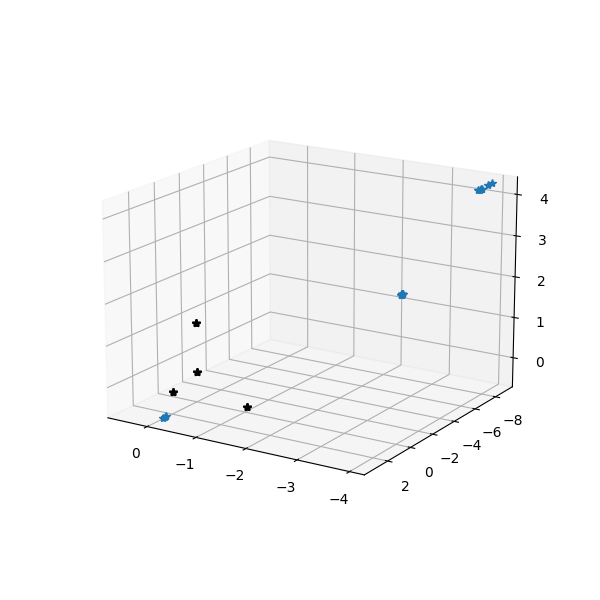

In [34]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=17, azim=122)
ax.plot(valid_positions[:,0], valid_positions[:,1],
            valid_positions[:,2],'*')

for each in range(4):
    ax.plot(mic_positions[:,0],mic_positions[:,1],mic_positions[:,2],'k*')

### Distance of positions from central microphone - acoustic tracking 



In [35]:
mic_positions[0,:]

array([ 0.00000000e+00, -4.18785789e-06,  0.00000000e+00])

In [36]:

def calc_dist_to_m0(X, refpos):
    try:
        distance = spatial.distance.euclidean(X,refpos)
    except ValueError:
        distance = np.nan
    return distance
dist_to_mic0 = np.apply_along_axis(calc_dist_to_m0,1,valid_positions,mic_positions[0,:])
dist_to_mic0

array([ 6.02812109,  6.04024204,  6.05386406,  6.06512339,  6.05809848,
        6.05099821,  6.04246166,  6.02803043,  6.07527302,  3.10029644,
       10.02094472,  3.16946061, 10.10677051, 10.1382057 , 10.18261291,
        3.05552342, 10.4125941 , 10.59340394])

In [37]:
print(np.mean(dist_to_mic0[:8]), np.nanstd(dist_to_mic0[:8]))

6.045867419925355 0.012683637828024303


Another way to estimate distance from speaker to mic0 is to utilise the digital copy of the playback signal. We can then estimate the time of flight of the playback. 

<IPython.core.display.Javascript object>


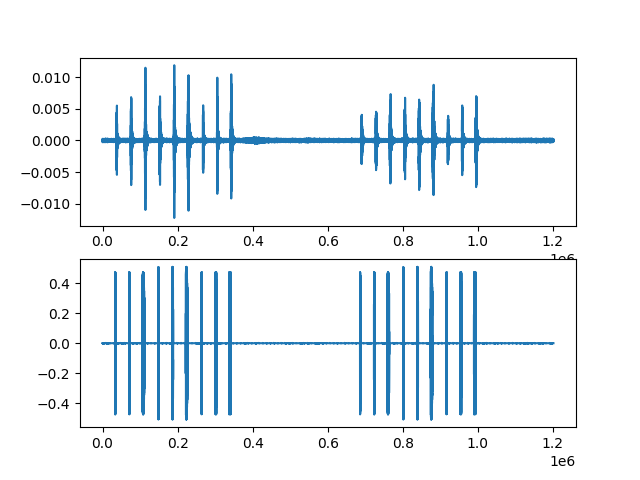

In [38]:
# crosscorrelate the output signal with channel 0. 
output_ch = cam_audio[:,-2]
plt.figure()
a0 = plt.subplot(211)
plt.plot(array_audiohp[:,0])
plt.subplot(212,sharex=a0)
plt.plot(output_ch)

In [39]:
ind_forcc = [30000, 80000]
cc = signal.correlate(array_audiohp[ind_forcc[0]:ind_forcc[1],0], cam_audio[ind_forcc[0]:ind_forcc[1],-2],'same')
delay = (np.argmax(cc)-cc.size/2.0)/fs
delay

0.017666666666666667

### Getting mic0-speaker distance through the time of flight

In [40]:
print(f'The sync-channel delay based mic0-speaker distance is {delay*340.0} m')

The sync-channel delay based mic0-speaker distance is 6.006666666666667 m


### Distance of positions from central mic - video tracking

In [41]:
# get video tracked speaker positions
speaker_posns = pd.read_csv('video_tracking/speaker_pbks/DLTdv7_data_2018-07-28_p03_2000_spkr_pbksxyzpts.csv')
speaker_posns.columns = ['x','y','z']
speaker_posns['frame_num'] = speaker_posns['x'].index+1
speaker_posns = speaker_posns[~pd.isna(speaker_posns['x'])]
speaker_posns

,x,y,z,frame_num
0,0.008015,2.229281,-0.078225,1
4,0.017248,2.213429,-0.073621,5
9,0.008970,2.219483,-0.071139,10
14,0.010627,2.222088,-0.077738,15
19,0.017311,2.203463,-0.078932,20
24,0.012832,2.216710,-0.079252,25
29,0.020581,2.190977,-0.072187,30
34,0.018498,2.204841,-0.067472,35
39,0.015844,2.202080,-0.068835,40
44,0.015176,2.218292,-0.077634,45


In [42]:
# choose only those frames with current playbacks 
pbk_posns_only = speaker_posns[speaker_posns['frame_num'].isin(playback_frames)]
pbk_posns_only

,x,y,z,frame_num
4,0.017248,2.213429,-0.073621,5
9,0.008970,2.219483,-0.071139,10
14,0.010627,2.222088,-0.077738,15
19,0.017311,2.203463,-0.078932,20
24,0.012832,2.216710,-0.079252,25
29,0.020581,2.190977,-0.072187,30
34,0.018498,2.204841,-0.067472,35
39,0.015844,2.202080,-0.068835,40
44,0.015176,2.218292,-0.077634,45
89,0.630240,2.209804,-1.058441,90


In [43]:
video_mic_positions = pd.read_csv('video_tracking/mic_positions_video/DLTdv7_data_mics9-12positionsxyzpts.csv')
mic_xyz = video_mic_positions[~pd.isna(video_mic_positions['pt1_X'])].reset_index(drop=True)
mic_xyz.columns=['x','y','z']
mic_xyz

,x,y,z
0,-0.162229,-3.854878,0.097387
1,-1.084803,-3.256231,-0.437829
2,0.278436,-4.036286,-0.544380
3,-0.118366,-3.985202,1.299513


The first speaker position in the video corresponds to the set of first playbacks (first 9 detections). Let's see the mic0 to speaker distance estimated here. 

In [44]:
speaker_posns_video = pbk_posns_only[['x','y','z']].to_numpy()
mic_positions_video = mic_xyz.to_numpy()

# set all video positions w.r.t to mic0
speaker_posns_video = speaker_posns_video - mic_positions_video[0,:]
mic_positions_video = mic_positions_video - mic_positions_video[0,:]


In [45]:
speaker_posns_video

array([[ 0.179477,  6.068307, -0.171008],
       [ 0.171199,  6.074361, -0.168526],
       [ 0.172856,  6.076966, -0.175125],
       [ 0.17954 ,  6.058341, -0.176319],
       [ 0.175061,  6.071588, -0.176639],
       [ 0.18281 ,  6.045855, -0.169574],
       [ 0.180727,  6.059719, -0.164859],
       [ 0.178073,  6.056958, -0.166222],
       [ 0.177405,  6.07317 , -0.175021],
       [ 0.792469,  6.064682, -1.155828],
       [ 0.796977,  6.051353, -1.159034],
       [ 0.800219,  6.046452, -1.150196],
       [ 0.79935 ,  6.039186, -1.145362],
       [ 0.810579,  6.054218, -1.14298 ],
       [ 0.807427,  6.045962, -1.138167],
       [ 0.807197,  6.027195, -1.130399],
       [ 0.807757,  6.029992, -1.123528],
       [ 0.824842,  6.020306, -1.110799]])

In [46]:
valid_positions

array([[-3.03592205, -4.83914   ,  1.92462612],
       [-3.04001144, -4.85016608,  1.92841487],
       [-3.04430021, -4.86301078,  1.93201272],
       [-3.04841236, -4.87323361,  1.9350811 ],
       [-3.04573063, -4.86700798,  1.93296565],
       [-3.04427263, -4.86035177,  1.92976809],
       [-3.04263428, -4.85193377,  1.92678459],
       [-3.0371349 , -4.83869646,  1.9235435 ],
       [-3.04902456, -4.88393477,  1.9389723 ],
       [-0.12297914,  3.03887206, -0.60161892],
       [-3.7939936 , -8.28900326,  4.16142284],
       [-0.10541444,  3.10536503, -0.62534021],
       [-3.81418817, -8.37854349,  4.17119381],
       [-3.82348446, -8.40613373,  4.18343968],
       [-3.83708062, -8.44820418,  4.19408331],
       [-0.13823806,  2.99753737, -0.57607136],
       [-3.90172919, -8.66388729,  4.2586095 ],
       [-3.95240772, -8.83012204,  4.3159818 ]])

<IPython.core.display.Javascript object>


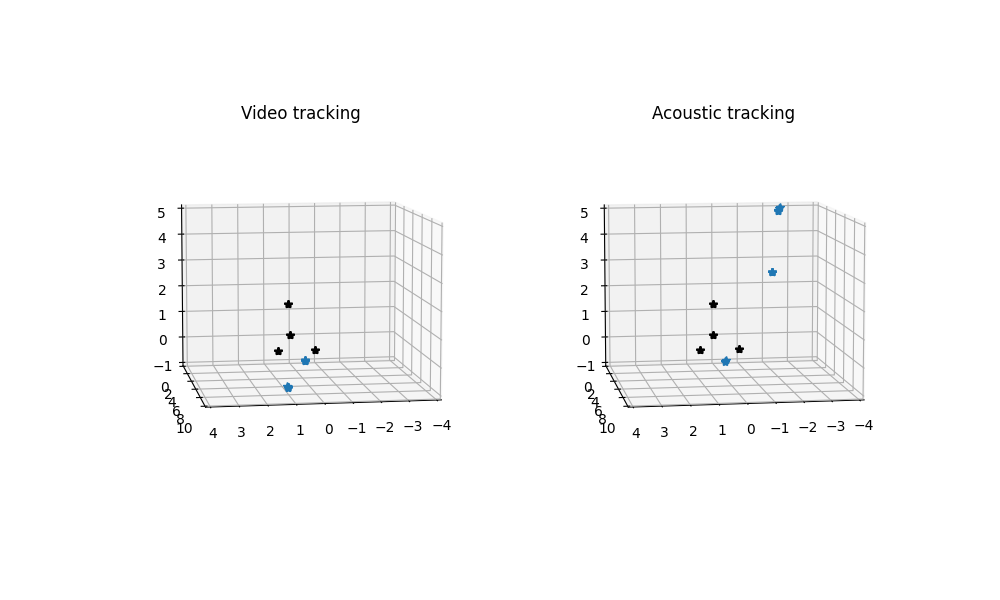

(-1.0, 5.0)

In [47]:
plt.figure(figsize=(10,6))
a1 = plt.subplot(121, projection='3d')
a1.view_init(elev=8, azim=81)
a1.plot(speaker_posns_video[:,0], speaker_posns_video[:,1],
            speaker_posns_video[:,2],'*')
plt.title('Video tracking')
for each in range(4):
    a1.plot(mic_positions_video[:,0],mic_positions_video[:,1],mic_positions_video[:,2],'k*')
a1.set_ylim(0,10)
a1.set_xlim(-4,4)
a1.set_zlim(-1,5)

a2 = plt.subplot(122, projection='3d')
plt.title('Acoustic tracking')
a2.view_init(elev=8, azim=81)
a2.plot(valid_positions[:,0], valid_positions[:,1],
            valid_positions[:,2],'*')

for each in range(4):
    a2.plot(mic_positions[:,0],mic_positions[:,1],mic_positions[:,2],'k*')
a2.set_ylim(0,10)
a2.set_xlim(-4,4)
a2.set_zlim(-1,5)

In [48]:
# video based tof-estimates
video_tofs = {}
for i, speaker_position in enumerate(speaker_posns_video):
    position_tofs = []
    for each in mic_positions_video:
        position_tofs.append(spatial.distance.euclidean(each,speaker_position)/338.0)
    video_tofs[i] = np.array(position_tofs)
video_tof_tdoas = {}
# set 0 channel as ref
for i, tofs in video_tofs.items():
    video_tof_tdoas[i] = tofs[1:]-tofs[0]

In [49]:
# use video based tdoas to estimate positions
calculated_4_positions = np.zeros((len(video_tof_tdoas.keys()), 3,2))

for det_number, tdoas in video_tofs.items():
        d = (vsound*tdoas).reshape(-1,1)
        solution1, solution2 = sw02.spiesberger_wahlberg_solution(mic_positions, d)
        calculated_4_positions[det_number,:,0] = solution1
        calculated_4_positions[det_number,:,1] = solution2

In [50]:
calculated_4_positions[:,:,1]

array([[-1.18736686,  2.66376683, -0.4623306 ],
       [-1.19047927,  2.66546372, -0.46505813],
       [-1.19166092,  2.66774449, -0.4640491 ],
       [-1.18637699,  2.65928165, -0.46055114],
       [-1.19026156,  2.6633208 , -0.46281691],
       [-1.18185593,  2.6548015 , -0.45952032],
       [-1.18427994,  2.66107289, -0.46204527],
       [-1.18475832,  2.65852022, -0.46213527],
       [-1.18960239,  2.66510338, -0.46270773],
       [-1.18266543,  2.7566583 , -0.19438593],
       [-1.17937344,  2.75171238, -0.19158365],
       [-1.17591934,  2.75020656, -0.19161171],
       [-1.17393029,  2.74654998, -0.19170311],
       [-1.17308148,  2.75531429, -0.19124231],
       [-1.17157651,  2.75147293, -0.19170925],
       [-1.16668634,  2.74256293, -0.19086314],
       [-1.16583465,  2.74411418, -0.19199512],
       [-1.15671584,  2.74235088, -0.18913197]])

<IPython.core.display.Javascript object>


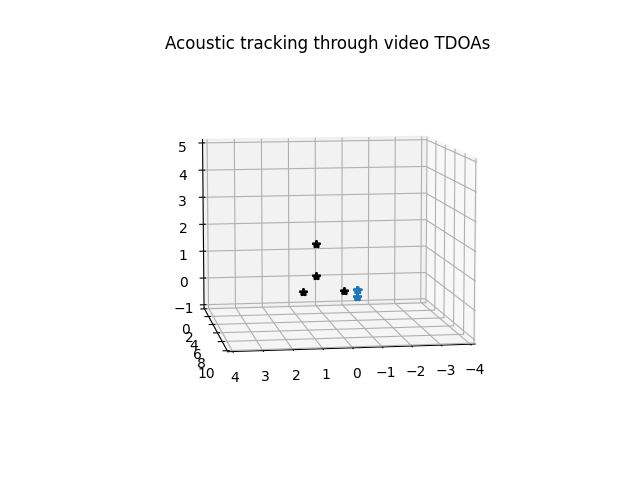

(-1.0, 5.0)

In [51]:
video_tdoas_basedpositions = calculated_4_positions[:,:,1]
plt.figure()
a2 = plt.subplot(111, projection='3d')
plt.title('Acoustic tracking through video TDOAs')
a2.view_init(elev=8, azim=81)
a2.plot(video_tdoas_basedpositions[:,0], video_tdoas_basedpositions[:,1],
            video_tdoas_basedpositions[:,2],'*')

for each in range(4):
    a2.plot(mic_positions[:,0],mic_positions[:,1],mic_positions[:,2],'k*')
a2.set_ylim(0,10)
a2.set_xlim(-4,4)
a2.set_zlim(-1,5)

### Camera based m0-speaker distance

## Conclusion : it's not all crap - acoustic tracking and video tracking do work -- but needs more troubleshooting!

* The camera based m0-speaker estimate is 6.08m
* Acoustic tracking based m0-speaker estimate is 5.96 $\pm$ 0.03 m (mean, sd)
    * The time-of-flight based m0-speaker estimate is 6.0 m

### Important lessons

* Audio processing is *very* important - the reverberation below 40 kHz made a *huge* difference on the TOADs estimated. Choosing the correct bandpass parameters made all of the difference.
* GCC-PHAT is better than CC in identifying TDOAs

### Next steps
* Why are the acoustic tracking positions so off??!! Use the fact that we can estimate time-of-flight to calculate TDOAs and then check if at least then acoustic tracking is accurate.
* Now I'd like to push the same exercise to more playback positions, and finally then get to aligning the audio and video tracking systems into a common system. 
* The ```batracker``` detection routines need some tuning!

In [52]:
print(f'Notebook cell run at {dt.datetime.now()}')

Notebook cell run at 2021-06-28 11:29:48.304090
